In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy
import itertools
import tqdm
import datetime
from scipy.stats import linregress
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load CS2_CPOM radar freeboard, air temperature and wind speed data from 01/01/2020 - 31/12/2020
freebs = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])
temps = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_temp.nc')['Temperature'])
wind = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/ERA5_windspeed.nc')['Wind Speed'])

In [3]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

daily_freebs = []
daily_temps = []
daily_wind = []

for day in days:
    daily_freebs.append(np.nanmean(freebs[day]))
    daily_temps.append(np.nanmean(temps[day]))
    daily_wind.append(np.nanmean(wind[day]))

### create regional wind and temperature data

In [4]:
# calculate regional wind and temps

mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]

# function to calculate regional means 
def regions_WG(regs):
    WG_mean = np.full(4018,np.nan)
    WG_c = data.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean[day] = np.nanmean(WG_c[day])
    return(WG_mean)

# regional average wind speed and temperature
temp_days = np.full(len(regs),np.nan)
wind_days = np.full(len(regs),np.nan)

for count in np.arange(0,len(regs)):
    region = regions[count]
    reg = regs[count]   

    data = temps
    region_temps = regions_WG(reg)
    temp_days[count] = np.nanmean(region_temps)

    data = wind
    region_wind = regions_WG(reg)
    wind_days[count] = np.nanmean(region_wind)

### calculate correlations and slopes

In [5]:
# do smooth anoms for each grid cell

T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

data = [temps, freebs, wind]

fb_running_mean_anoms = np.full(freebs.shape,np.nan)
temp_running_mean_anoms = np.full(freebs.shape,np.nan)
wind_running_mean_anoms = np.full(freebs.shape,np.nan)

rmas = [temp_running_mean_anoms, fb_running_mean_anoms, wind_running_mean_anoms]

for dat,rma in zip(data,rmas):
    
    anoms_big = np.full(dat.shape,np.nan)

    for day in tqdm.trange(freebs.shape[0]):

        # 31-day running mean for each grid cell in time dimension
        monthly = np.nanmean(dat[day-T1:day+T1],axis=0) 

        # now make anomalies from 30 day means

        anoms_big[day] = dat[day] - monthly 

    # 9 day mean of anoms for each grid cell in time dimension
    for day in tqdm.trange(dat.shape[0]):

        rma[day] = np.nanmean(anoms_big[day-T2:day+T2],axis=0) 

100%|██████████████████████████████████████| 4018/4018 [00:15<00:00, 253.76it/s]


In [6]:
## calculate correlation and slope for each grid cell

ss_temp = np.full((freebs.shape[1],freebs.shape[2]), np.nan)
ps_temp = np.full((freebs.shape[1],freebs.shape[2]), np.nan)
rs_temp = np.full((freebs.shape[1],freebs.shape[2]), np.nan)
ss_wind = np.full((freebs.shape[1],freebs.shape[2]), np.nan)
ps_wind = np.full((freebs.shape[1],freebs.shape[2]), np.nan)
rs_wind = np.full((freebs.shape[1],freebs.shape[2]), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(freebs.shape[1]),
                              np.arange(freebs.shape[2]))):
    
    mask_temp = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(temp_running_mean_anoms[:,i,j]) # mask out cells with nan temp or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask_temp)) > 2: # if more than 2 days in snow and freeb have data then continue
        
        rstats = linregress(temp_running_mean_anoms[:,i,j][mask_temp],fb_running_mean_anoms[:,i,j][mask_temp]) # correlate valid temp and freeb for each grid cell 
        s = rstats.slope
        p = rstats.pvalue
        r = rstats.rvalue
        ss_temp[i,j] = s
        ps_temp[i,j] = p
        rs_temp[i,j] = r
        
    mask_wind = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(wind_running_mean_anoms[:,i,j]) # mask out cells with nan wind or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask_wind)) > 2: # if more than 2 days in snow and freeb have data then continue
        
        rstats = linregress(wind_running_mean_anoms[:,i,j][mask_wind],fb_running_mean_anoms[:,i,j][mask_wind]) # correlate valid wind and freeb for each grid cell 
        s = rstats.slope
        p = rstats.pvalue
        r = rstats.rvalue
        ss_wind[i,j] = s
        ps_wind[i,j] = p
        rs_wind[i,j] = r

129600it [00:24, 5363.98it/s]


### plot figure

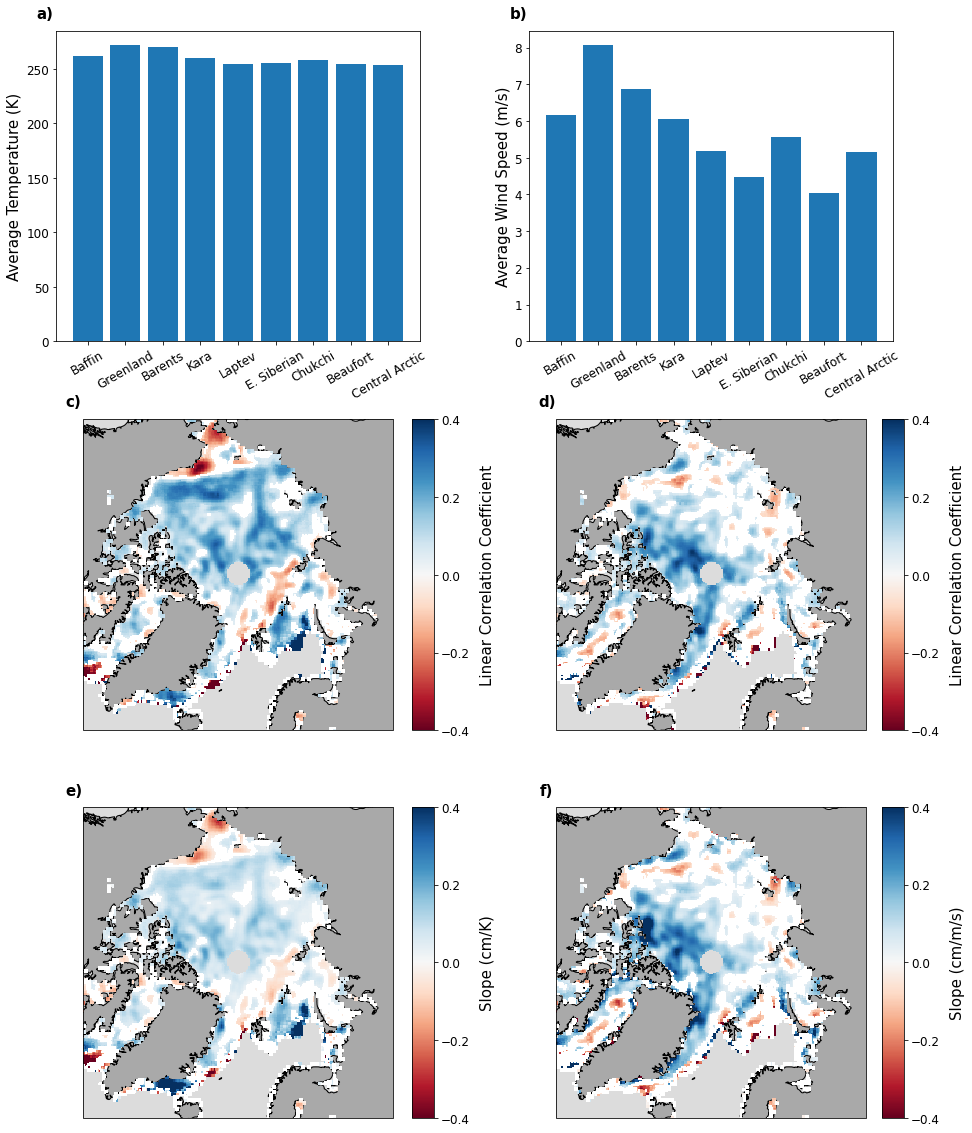

In [7]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')

fig = plt.figure(figsize = (15,20))
spec = gridspec.GridSpec(ncols=2, nrows=3,hspace=0.25,wspace=0.3)

## average temperature and wind speed 

ax1 = fig.add_subplot(spec[0])
ax1 = plt.bar(regions, temp_days, 0.8, color='tab:blue')
plt.title('a)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
plt.ylabel("Average Temperature (K)",fontsize=15)
plt.xticks(rotation=30,fontsize='large')
plt.yticks(fontsize=12)

ax2 = fig.add_subplot(spec[1])
ax2 = plt.bar(regions, wind_days, 0.8, color='tab:blue')
plt.title('b)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
plt.ylabel("Average Wind Speed (m/s)",fontsize=15)
plt.xticks(rotation=30,fontsize='large')
plt.yticks(fontsize=12)

## correlations

ax3 = fig.add_subplot(spec[2], projection=ccrs.NorthPolarStereo())
ss_temp[ps_temp>0.05] = 1000
grey = ss_temp.copy()
grey[grey <1000] = np.nan
ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax3.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax3.coastlines()
ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax3.pcolormesh(lons,lats,rs_temp,cmap='RdBu',
                       vmin=-0.4,vmax=0.4,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax3.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('c)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
cbar_ax = fig.add_axes([0.455, 0.394, 0.02, 0.216])
a = fig.colorbar(p_map, cax=cbar_ax,ticks=[-0.4,-0.2,0,0.2,0.4])
a.ax.tick_params(labelsize=12)
a.set_label('Linear Correlation Coefficient',labelpad=10,fontsize=15)

ax4 = fig.add_subplot(spec[3], projection=ccrs.NorthPolarStereo())
ss_wind[ps_wind>0.05] = 1000
grey = ss_wind.copy()
grey[grey <1000] = np.nan
ax4.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax4.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax4.coastlines()
ax4.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax4.pcolormesh(lons,lats,rs_wind,cmap='RdBu',
                       vmin=-0.4,vmax=0.4,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax4.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('d)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
cbar_ax = fig.add_axes([0.89, 0.394, 0.02, 0.216])
a = fig.colorbar(p_map, cax=cbar_ax,ticks=[-0.4,-0.2,0,0.2,0.4])
a.ax.tick_params(labelsize=12)
a.set_label('Linear Correlation Coefficient',fontsize=15,labelpad=10)

## slopes

ax5 = fig.add_subplot(spec[4], projection=ccrs.NorthPolarStereo())
ss_temp[ps_temp>0.05] = 1000
grey = ss_temp.copy()
grey[grey <1000] = np.nan
ax5.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax5.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax5.coastlines()
ax5.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax5.pcolormesh(lons,lats,ss_temp*100,cmap='RdBu',
                       vmin=-0.4,vmax=0.4,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax5.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('e)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
cbar_ax = fig.add_axes([0.455, 0.125, 0.02, 0.216])
a = fig.colorbar(p_map, cax=cbar_ax,ticks=[-0.4,-0.2,0,0.2,0.4])
a.ax.tick_params(labelsize=12)
a.set_label('Slope (cm/K)',labelpad=10,fontsize=15)

ax6 = fig.add_subplot(spec[5], projection=ccrs.NorthPolarStereo())
ss_wind[ps_wind>0.05] = 1000
grey = ss_wind.copy()
grey[grey <1000] = np.nan
ax6.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=0)
ax6.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
ax6.coastlines()
ax6.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax6.pcolormesh(lons,lats,ss_wind*100,cmap='RdBu',
                       vmin=-0.4,vmax=0.4,
                       alpha=1.0, transform=ccrs.PlateCarree())
ax6.pcolormesh(lons,lats,grey,cmap='Greys',vmin=1000,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
plt.title('f)', x = -0.03,y = 1.02,fontweight="bold",fontsize=15)
cbar_ax = fig.add_axes([0.89, 0.125, 0.02, 0.216])
a = fig.colorbar(p_map, cax=cbar_ax,ticks=[-0.4,-0.2,0,0.2,0.4])
a.ax.tick_params(labelsize=12)
a.set_label('Slope (cm/m/s)',fontsize=15,labelpad=10)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/temp_wind.png',bbox_inches = "tight")